# Production Model and Insights - Garage Crafters

In [1093]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

import statsmodels.api as sm

## Load clean training and test data

In [1094]:
train = pd.read_csv('../data/cleaned_data/train_clean.csv')
test = pd.read_csv('../data/cleaned_data/test_clean.csv')

## Focused EDA

In [1095]:
def dummies(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns = categorical_columns, drop_first=True)
    
    return df

In [1096]:
garage_crafters = train[[ 
'Garage Area',
'Garage Cars',
'Garage Cond',
'Garage Finish',
'Garage Qual',
'Garage Type',
'Garage Yr Blt',
'Gr Liv Area',
'Neighborhood',
'SalePrice'
]]

In [1097]:
garage_crafters_dummies = dummies(garage_crafters)

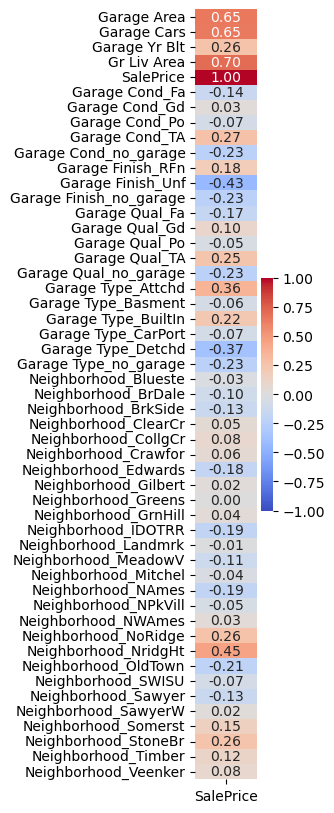

In [1098]:
plt.figure(figsize = (1,10))
sns.heatmap(garage_crafters_dummies.corr()[['SalePrice']], cmap='coolwarm', fmt=".2f", vmin= -1, annot=True);

In [1099]:
garage_only_dummies = dummies(garage_only)

In [1100]:
garage_corr = garage_only_dummies.corr()['SalePrice'].sort_values(ascending=False)

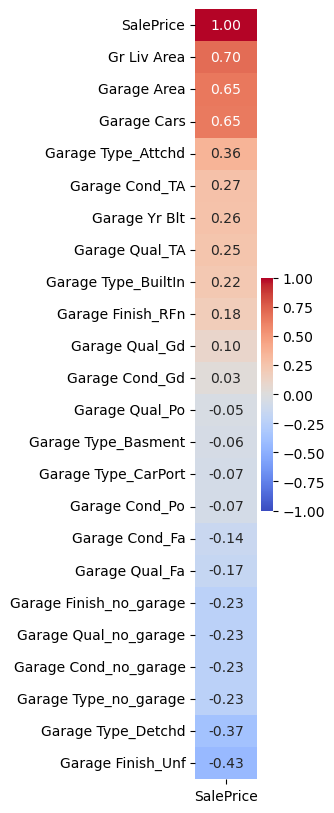

In [1101]:
plt.figure(figsize = (1,10))
sns.heatmap(garage_only_dummies[garage_corr.index].corr()[['SalePrice']], cmap='coolwarm', fmt=".2f", vmin= -1, annot=True);

In [1102]:
plt.figure(figsize = (12,12))
sns.heatmap(garage_only_dummies.corr(), cmap='coolwarm', fmt=".1f", vmin= -1, annot=True);

## Predictors and target Variables

In [1103]:
predictors = [
'Garage Area',
'Garage Cars',
'Garage Cond',
'Garage Finish',
'Garage Qual',
'Garage Type',
'Garage Yr Blt',
'Gr Liv Area',
'Neighborhood'
]

In [1104]:
X = train[predictors]
y = train['SalePrice']

## Split data into train and test sets

In [1105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 21)

In [1106]:
X_train.shape, y_test.shape

((1640, 9), (411,))

## Column Transformer

In [1107]:
categorical_cols = train[predictors].select_dtypes(exclude=['number']).columns.tolist()

In [1108]:
categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [1109]:
ct = make_column_transformer(
    (categorical_transformer, categorical_cols),
    remainder='passthrough'
)

## Transform training and testing data

In [1110]:
X_train_ct = ct.fit_transform(X_train)

/Users/nolan/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1111]:
X_test_ct = ct.transform(X_test)

In [1112]:
column_names = ct.get_feature_names_out()

In [1113]:
column_names

array(['onehotencoder__Garage Cond_Ex', 'onehotencoder__Garage Cond_Fa',
       'onehotencoder__Garage Cond_Gd', 'onehotencoder__Garage Cond_Po',
       'onehotencoder__Garage Cond_TA',
       'onehotencoder__Garage Cond_no_garage',
       'onehotencoder__Garage Finish_Fin',
       'onehotencoder__Garage Finish_RFn',
       'onehotencoder__Garage Finish_Unf',
       'onehotencoder__Garage Finish_no_garage',
       'onehotencoder__Garage Qual_Ex', 'onehotencoder__Garage Qual_Fa',
       'onehotencoder__Garage Qual_Gd', 'onehotencoder__Garage Qual_Po',
       'onehotencoder__Garage Qual_TA',
       'onehotencoder__Garage Qual_no_garage',
       'onehotencoder__Garage Type_2Types',
       'onehotencoder__Garage Type_Attchd',
       'onehotencoder__Garage Type_Basment',
       'onehotencoder__Garage Type_BuiltIn',
       'onehotencoder__Garage Type_CarPort',
       'onehotencoder__Garage Type_Detchd',
       'onehotencoder__Garage Type_no_garage',
       'onehotencoder__Neighborhood_Blmngt

In [1114]:
X_train_ct_df = pd.DataFrame(X_train_ct, columns=column_names)

## Drop 'no_garage' Dummy Columns

In [1115]:
no_garage_columns = [col for col in X_train_ct_df.columns if 'no_garage' in col]

In [1116]:
X_train_ct_df.drop(columns=no_garage_columns, inplace=True)

## Initialize and train Linear Regression Model

In [1117]:
model = LinearRegression()
model.fit(X_train_ct, y_train)

LinearRegression()

## Evaluate Model

In [1118]:
# scoring model on training set
model.score(X_train_ct, y_train)

0.8008499286649029

In [1119]:
#scoring model on testing set
model.score(X_test_ct, y_test)

-1.985258111950344e+17

In [1120]:
np.mean(cross_val_score(model, X_test_ct, y_test, cv=5))

-6480247556470446.0

In [1121]:
# setting baseline
y_pred_baseline = [np.mean(y_train)] * len(y_test)

In [1122]:
# scoring mean baseline on testing set
r2_score(y_test, y_pred_baseline)

-0.014887741251467856

## Transform and Make Predictions on Unseen Testing Set

In [1123]:
test_features = test[predictors]
test_features_ct = ct.transform(test_features)

In [1124]:
predictions = model.predict(test_features_ct)

In [1125]:
predictions_df = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})

## OLS

In [1126]:
y_train.reset_index(drop=True, inplace=True)
X_train_ct_df.reset_index(drop=True, inplace=True)

In [1127]:
X_train_ct_df = sm.add_constant(X_train_ct_df)

In [1128]:
ols = sm.OLS(y_train, X_train_ct_df).fit()

In [1129]:
ols_summary = ols.summary()

In [1130]:
ols_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     136.3
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        06:13:09   Log-Likelihood:                -19533.
No. Observations:                1640   AIC:                         3.916e+04
Df Residuals:                    1592   BIC:                         3.942e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                5.749e+04   5406.789     10.633      0.000    4.69e+04    6.81e+04
onehotencoder__Garage Cond_Ex        -1.43e+05   4.84e+04     -2.956      0.003   -2.38e+05   -4.81e+04
onehotencoder__Garage Cond_Fa        1.469e+04   3.27e+04      0.449      0.653   -4.94e+04    7.88e+04
onehotencoder__Garage Cond_Gd        8014.9060   3.43e+04      0.234      0.815   -5.92e+04    7.52e+04
onehotencoder__Garage Cond_Po       -1532.5948   3.44e+04     -0.045      0.964    -6.9e+04     6.6e+04
onehotencoder__Garage Cond_TA        2.184e+04   3.28e+04      0.667      0.505   -4.24e+04    8.61e+04
onehotencoder__Garage Finish_Fin    -2.018e+04   5.15e+04     -0.392      0.695   -1.21e+05    8.09e+04
onehotencoder__Garage Finish_RFn    -3.895e+04   5.13e+04     -0.759      0.448    -1.4e+05    6.17e+04
onehotencoder__Garage Finish_Unf    -4.086e+04    5.1e+04     -0.802      0.423   -1.41e+05    5.91e+04
onehotencoder__Garage Qual_Ex        1.192e+05   4.46e+04      2.673      0.008    3.17e+04    2.07e+05
onehotencoder__Garage Qual_Fa       -6.142e+04   3.13e+04     -1.960      0.050   -1.23e+05      59.567
onehotencoder__Garage Qual_Gd       -2.502e+04   3.45e+04     -0.725      0.468   -9.27e+04    4.26e+04
onehotencoder__Garage Qual_Po       -7.278e+04   4.55e+04     -1.600      0.110   -1.62e+05    1.65e+04
onehotencoder__Garage Qual_TA       -5.995e+04   3.23e+04     -1.854      0.064   -1.23e+05    3471.697
onehotencoder__Garage Type_2Types   -5.015e+04   2.58e+04     -1.947      0.052   -1.01e+05     368.262
onehotencoder__Garage Type_Attchd    9316.4197    2.6e+04      0.359      0.720   -4.16e+04    6.02e+04
onehotencoder__Garage Type_Basment  -1.301e+04   2.68e+04     -0.485      0.628   -6.56e+04    3.96e+04
onehotencoder__Garage Type_BuiltIn   -280.0627   2.64e+04     -0.011      0.992   -5.21e+04    5.16e+04
onehotencoder__Garage Type_CarPort  -3.771e+04   2.91e+04     -1.298      0.195   -9.47e+04    1.93e+04
onehotencoder__Garage Type_Detchd   -8151.1064    2.6e+04     -0.313      0.754   -5.92e+04    4.29e+04
onehotencoder__Neighborhood_Blmngtn -4745.9083   8745.566     -0.543      0.587   -2.19e+04    1.24e+04
onehotencoder__Neighborhood_Blueste -3.306e+04    1.6e+04     -2.072      0.038   -6.44e+04   -1761.811
onehotencoder__Neighborhood_BrDale  -1.885e+04   9336.376     -2.019      0.044   -3.72e+04    -539.419
onehotencoder__Neighborhood_BrkSide -1.424e+04   5482.463     -2.597      0.009    -2.5e+04   -3484.338
onehotencoder__Neighborhood_ClearCr  6222.8111   7767.686      0.801      0.423   -9013.157    2.15e+04
onehotencoder__Neighborhood_CollgCr  4048.4456   3833.854      1.056      0.291   -3471.487    1.16e+04
onehotencoder__Neighborhood_Crawfor  1.756e+04   5312.304      3.30

In [1131]:
#This cell written with the help of ChatGPT
ols_summary_df = pd.read_html(ols_summary.tables[1].as_html(), header=0, index_col=0)[0]

In [1132]:
ols_summary_df

coef    std err       t  P>|t|  \
const                                 57490.0000  5406.7890 10.6330 0.0000   
onehotencoder__Garage Cond_Ex       -143000.0000 48400.0000 -2.9560 0.0030   
onehotencoder__Garage Cond_Fa         14690.0000 32700.0000  0.4490 0.6530   
onehotencoder__Garage Cond_Gd          8014.9060 34300.0000  0.2340 0.8150   
onehotencoder__Garage Cond_Po         -1532.5948 34400.0000 -0.0450 0.9640   
onehotencoder__Garage Cond_TA         21840.0000 32800.0000  0.6670 0.5050   
onehotencoder__Garage Finish_Fin     -20180.0000 51500.0000 -0.3920 0.6950   
onehotencoder__Garage Finish_RFn     -38950.0000 51300.0000 -0.7590 0.4480   
onehotencoder__Garage Finish_Unf     -40860.0000 51000.0000 -0.8020 0.4230   
onehotencoder__Garage Qual_Ex        119200.0000 44600.0000  2.6730 0.0080   
onehotencoder__Garage Qual_Fa        -61420.0000 31300.0000 -1.9600 0.0500   
onehotencoder__Garage Qual_Gd        -25020.0000 34500.0000 -0.7250 0.4680   
onehotencoder__Garage Qual_Po        -72780.0000 45500.0000 -1.6000 0.1100   
onehotencoder__Garage Qual_TA        -59950.0000 32300.0000 -1.8540 0.0640   
onehotencoder__Garage Type_2Types    -50150.0000 25800.0000 -1.9470 0.0520   
onehotencoder__Garage Type_Attchd      9316.4197 26000.0000  0.3590 0.7200   
onehotencoder__Garage Type_Basment   -13010.0000 26800.0000 -0.4850 0.6280   
onehotencoder__Garage Type_BuiltIn     -280.0627 26400.0000 -0.0110 0.9920   
onehotencoder__Garage Type_CarPort   -37710.0000 29100.0000 -1.2980 0.1950   
onehotencoder__Garage Type_Detchd     -8151.1064 26000.0000 -0.3130 0.7540   
onehotencoder__Neighborhood_Blmngtn   -4745.9083  8745.5660 -0.5430 0.5870   
onehotencoder__Neighborhood_Blueste  -33060.0000 16000.0000 -2.0720 0.0380   
onehotencoder__Neighborhood_BrDale   -18850.0000  9336.3760 -2.0190 0.0440   
onehotencoder__Neighborhood_BrkSide  -14240.0000  5482.4630 -2.5970 0.0090   
onehotencoder__Neighborhood_ClearCr    6222.8111  7767.6860  0.8010 0.4230   
onehotencoder__Neighborhood_CollgCr    4048.4456  3833.8540  1.0560 0.2910   
onehotencoder__Neighborhood_Crawfor   17560.0000  5312.3040  3.3050 0.0010   
onehotencoder__Neighborhood_Edwards  -20490.0000  4116.4330 -4.9760 0.0000   
onehotencoder__Neighborhood_Gilbert  -14490.0000  4736.5200 -3.0590 0.0020   
onehotencoder__Neighborhood_Greens    -2872.5626 20600.0000 -0.1400 0.8890   
onehotencoder__Neighborhood_GrnHill  107900.0000 25100.0000  4.2930 0.0000   
onehotencoder__Neighborhood_IDOTRR   -42000.0000  6165.6540 -6.8120 0.0000   
onehotencoder__Neighborhood_Landmrk  -22470.0000 35400.0000 -0.6350 0.5260   
onehotencoder__Neighborhood_MeadowV  -43720.0000  8549.1030 -5.1140 0.0000   
onehotencoder__Neighborhood_Mitchel   -9949.4017  5039.2920 -1.9740 0.0490   
onehotencoder__Neighborhood_NAmes    -16950.0000  3277.6750 -5.1710 0.0000   
onehotencoder__Neighborhood_NPkVill  -27460.0000  9759.5250 -2.8140 0.0050   
onehotencoder__Neighborhood_NWAmes   -15350.0000  4949.2240 -3.1020 0.0020   
onehotencoder__Neighborhood_NoRidge   44400.0000  6659.2350  6.6680 0.0000   
onehotencoder__Neighborhood_NridgHt   77700.0000  4628.0080 16.7900 0.0000   
onehotencoder__Neighborhood_OldTown  -32540.0000  4353.4920 -7.4750 0.0000   
onehotencoder__Neighborhood_SWISU    -20710.0000  7227.7910 -2.8650 0.0040   
onehotencoder__Neighborhood_Sawyer   -14990.0000  4515.3140 -3.3210 0.0010   
onehotencoder__Neighborhood_SawyerW   -9492.7990  4781.4320 -1.9850 0.0470   
onehotencoder__Neighborhood_Somerst   17500.0000  4380.8060  3.9950 0.0000   
onehotencoder__Neighborhood_StoneBr   91070.0000  6812.4600 13.3680 0.0000   
onehotencoder__Neighborhood_Timber    26820.0000  6301.2920  4.2560 0.0000   
onehotencoder__Neighborhood_Veenker   28650.0000 10100.0000  2.8400 0.0050   
remainder__Garage Area                   64.6845    10.6580  6.0690 0.0000   
remainder__Garage Cars                 8829.1207  3112.0880  2.8370 0.0050   
remainder__Garage Yr Blt                 30.6311    71.0430  0.431

In [1133]:
ols_summary_df.sort_values(by='coef', ascending=False)

coef    std err       t  P>|t|  \
onehotencoder__Garage Qual_Ex        119200.0000 44600.0000  2.6730 0.0080   
onehotencoder__Neighborhood_GrnHill  107900.0000 25100.0000  4.2930 0.0000   
onehotencoder__Neighborhood_StoneBr   91070.0000  6812.4600 13.3680 0.0000   
onehotencoder__Neighborhood_NridgHt   77700.0000  4628.0080 16.7900 0.0000   
const                                 57490.0000  5406.7890 10.6330 0.0000   
onehotencoder__Neighborhood_NoRidge   44400.0000  6659.2350  6.6680 0.0000   
onehotencoder__Neighborhood_Veenker   28650.0000 10100.0000  2.8400 0.0050   
onehotencoder__Neighborhood_Timber    26820.0000  6301.2920  4.2560 0.0000   
onehotencoder__Garage Cond_TA         21840.0000 32800.0000  0.6670 0.5050   
onehotencoder__Neighborhood_Crawfor   17560.0000  5312.3040  3.3050 0.0010   
onehotencoder__Neighborhood_Somerst   17500.0000  4380.8060  3.9950 0.0000   
onehotencoder__Garage Cond_Fa         14690.0000 32700.0000  0.4490 0.6530   
onehotencoder__Garage Type_Attchd      9316.4197 26000.0000  0.3590 0.7200   
remainder__Garage Cars                 8829.1207  3112.0880  2.8370 0.0050   
onehotencoder__Garage Cond_Gd          8014.9060 34300.0000  0.2340 0.8150   
onehotencoder__Neighborhood_ClearCr    6222.8111  7767.6860  0.8010 0.4230   
onehotencoder__Neighborhood_CollgCr    4048.4456  3833.8540  1.0560 0.2910   
remainder__Garage Area                   64.6845    10.6580  6.0690 0.0000   
remainder__Gr Liv Area                   59.9150     2.4570 24.3880 0.0000   
remainder__Garage Yr Blt                 30.6311    71.0430  0.4310 0.6660   
onehotencoder__Garage Type_BuiltIn     -280.0627 26400.0000 -0.0110 0.9920   
onehotencoder__Garage Cond_Po         -1532.5948 34400.0000 -0.0450 0.9640   
onehotencoder__Neighborhood_Greens    -2872.5626 20600.0000 -0.1400 0.8890   
onehotencoder__Neighborhood_Blmngtn   -4745.9083  8745.5660 -0.5430 0.5870   
onehotencoder__Garage Type_Detchd     -8151.1064 26000.0000 -0.3130 0.7540   
onehotencoder__Neighborhood_SawyerW   -9492.7990  4781.4320 -1.9850 0.0470   
onehotencoder__Neighborhood_Mitchel   -9949.4017  5039.2920 -1.9740 0.0490   
onehotencoder__Garage Type_Basment   -13010.0000 26800.0000 -0.4850 0.6280   
onehotencoder__Neighborhood_BrkSide  -14240.0000  5482.4630 -2.5970 0.0090   
onehotencoder__Neighborhood_Gilbert  -14490.0000  4736.5200 -3.0590 0.0020   
onehotencoder__Neighborhood_Sawyer   -14990.0000  4515.3140 -3.3210 0.0010   
onehotencoder__Neighborhood_NWAmes   -15350.0000  4949.2240 -3.1020 0.0020   
onehotencoder__Neighborhood_NAmes    -16950.0000  3277.6750 -5.1710 0.0000   
onehotencoder__Neighborhood_BrDale   -18850.0000  9336.3760 -2.0190 0.0440   
onehotencoder__Garage Finish_Fin     -20180.0000 51500.0000 -0.3920 0.6950   
onehotencoder__Neighborhood_Edwards  -20490.0000  4116.4330 -4.9760 0.0000   
onehotencoder__Neighborhood_SWISU    -20710.0000  7227.7910 -2.8650 0.0040   
onehotencoder__Neighborhood_Landmrk  -22470.0000 35400.0000 -0.6350 0.5260   
onehotencoder__Garage Qual_Gd        -25020.0000 34500.0000 -0.7250 0.4680   
onehotencoder__Neighborhood_NPkVill  -27460.0000  9759.5250 -2.8140 0.0050   
onehotencoder__Neighborhood_OldTown  -32540.0000  4353.4920 -7.4750 0.0000   
onehotencoder__Neighborhood_Blueste  -33060.0000 16000.0000 -2.0720 0.0380   
onehotencoder__Garage Type_CarPort   -37710.0000 29100.0000 -1.2980 0.1950   
onehotencoder__Garage Finish_RFn     -38950.0000 51300.0000 -0.7590 0.4480   
onehotencoder__Garage Finish_Unf     -40860.0000 51000.0000 -0.8020 0.4230   
onehotencoder__Neighborhood_IDOTRR   -42000.0000  6165.6540 -6.8120 0.0000   
onehotencoder__Neighborhood_MeadowV  -43720.0000  8549.1030 -5.1140 0.0000   
onehotencoder__Garage Type_2Types    -50150.0000 25800.0000 -1.9470 0.0520   
onehotencoder__Garage Qual_TA        -59950.0000 32300.0000 -1.8540 0.0640   
onehotencoder__Garage Qual_Fa        -61420.0000 31300.0000 -1.9600 0.0500   
onehotencoder__Garage Qual_Po        -72780.0000 45500.0000 -1.600